# Эксперимент №1
https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set

In [1]:
import sys
import os

sys.path.append('..')
folder_path = os.path.abspath(os.path.join(os.getcwd(), "../../evaluate"))
sys.path.append(folder_path)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tools import deletion_features
from tools import balancing
from tools import encoder
from tools import scaling
from Alg_CatBoost import CatBoostRegressor_fill 
from Alg_DecisionTree import DecisionTreeRegressor_fill
from Alg_Interpolate import interpolate_fill
from Alg_KNNImputer import KNNImputer_fill
from Alg_LinearRegression import LinearRegression_fill
from Alg_max import max_fill
from Alg_mean import mean_fill 
from Alg_median import median_fill
from Alg_min import min_fill
from Alg_RandomForestRegressor import RandomForestRegressor_fill
from Alg_SVR import SVR_fill
from Alg_XGBRegressor import XGBRegressor_fill
import results_metrics
import results_metrics_visualization

In [3]:
#считываем тренировочные данные
df = pd.read_csv('./Data/Maternal Health Risk Data Set.csv')

df.shape

(1014, 7)

# 1. Исследуем данные

In [4]:
df.head()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

In [5]:
#проверим данные на типы
df.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [6]:
#проверим на пропуски
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [7]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [8]:
print(len(df.columns))

7


<AxesSubplot:>

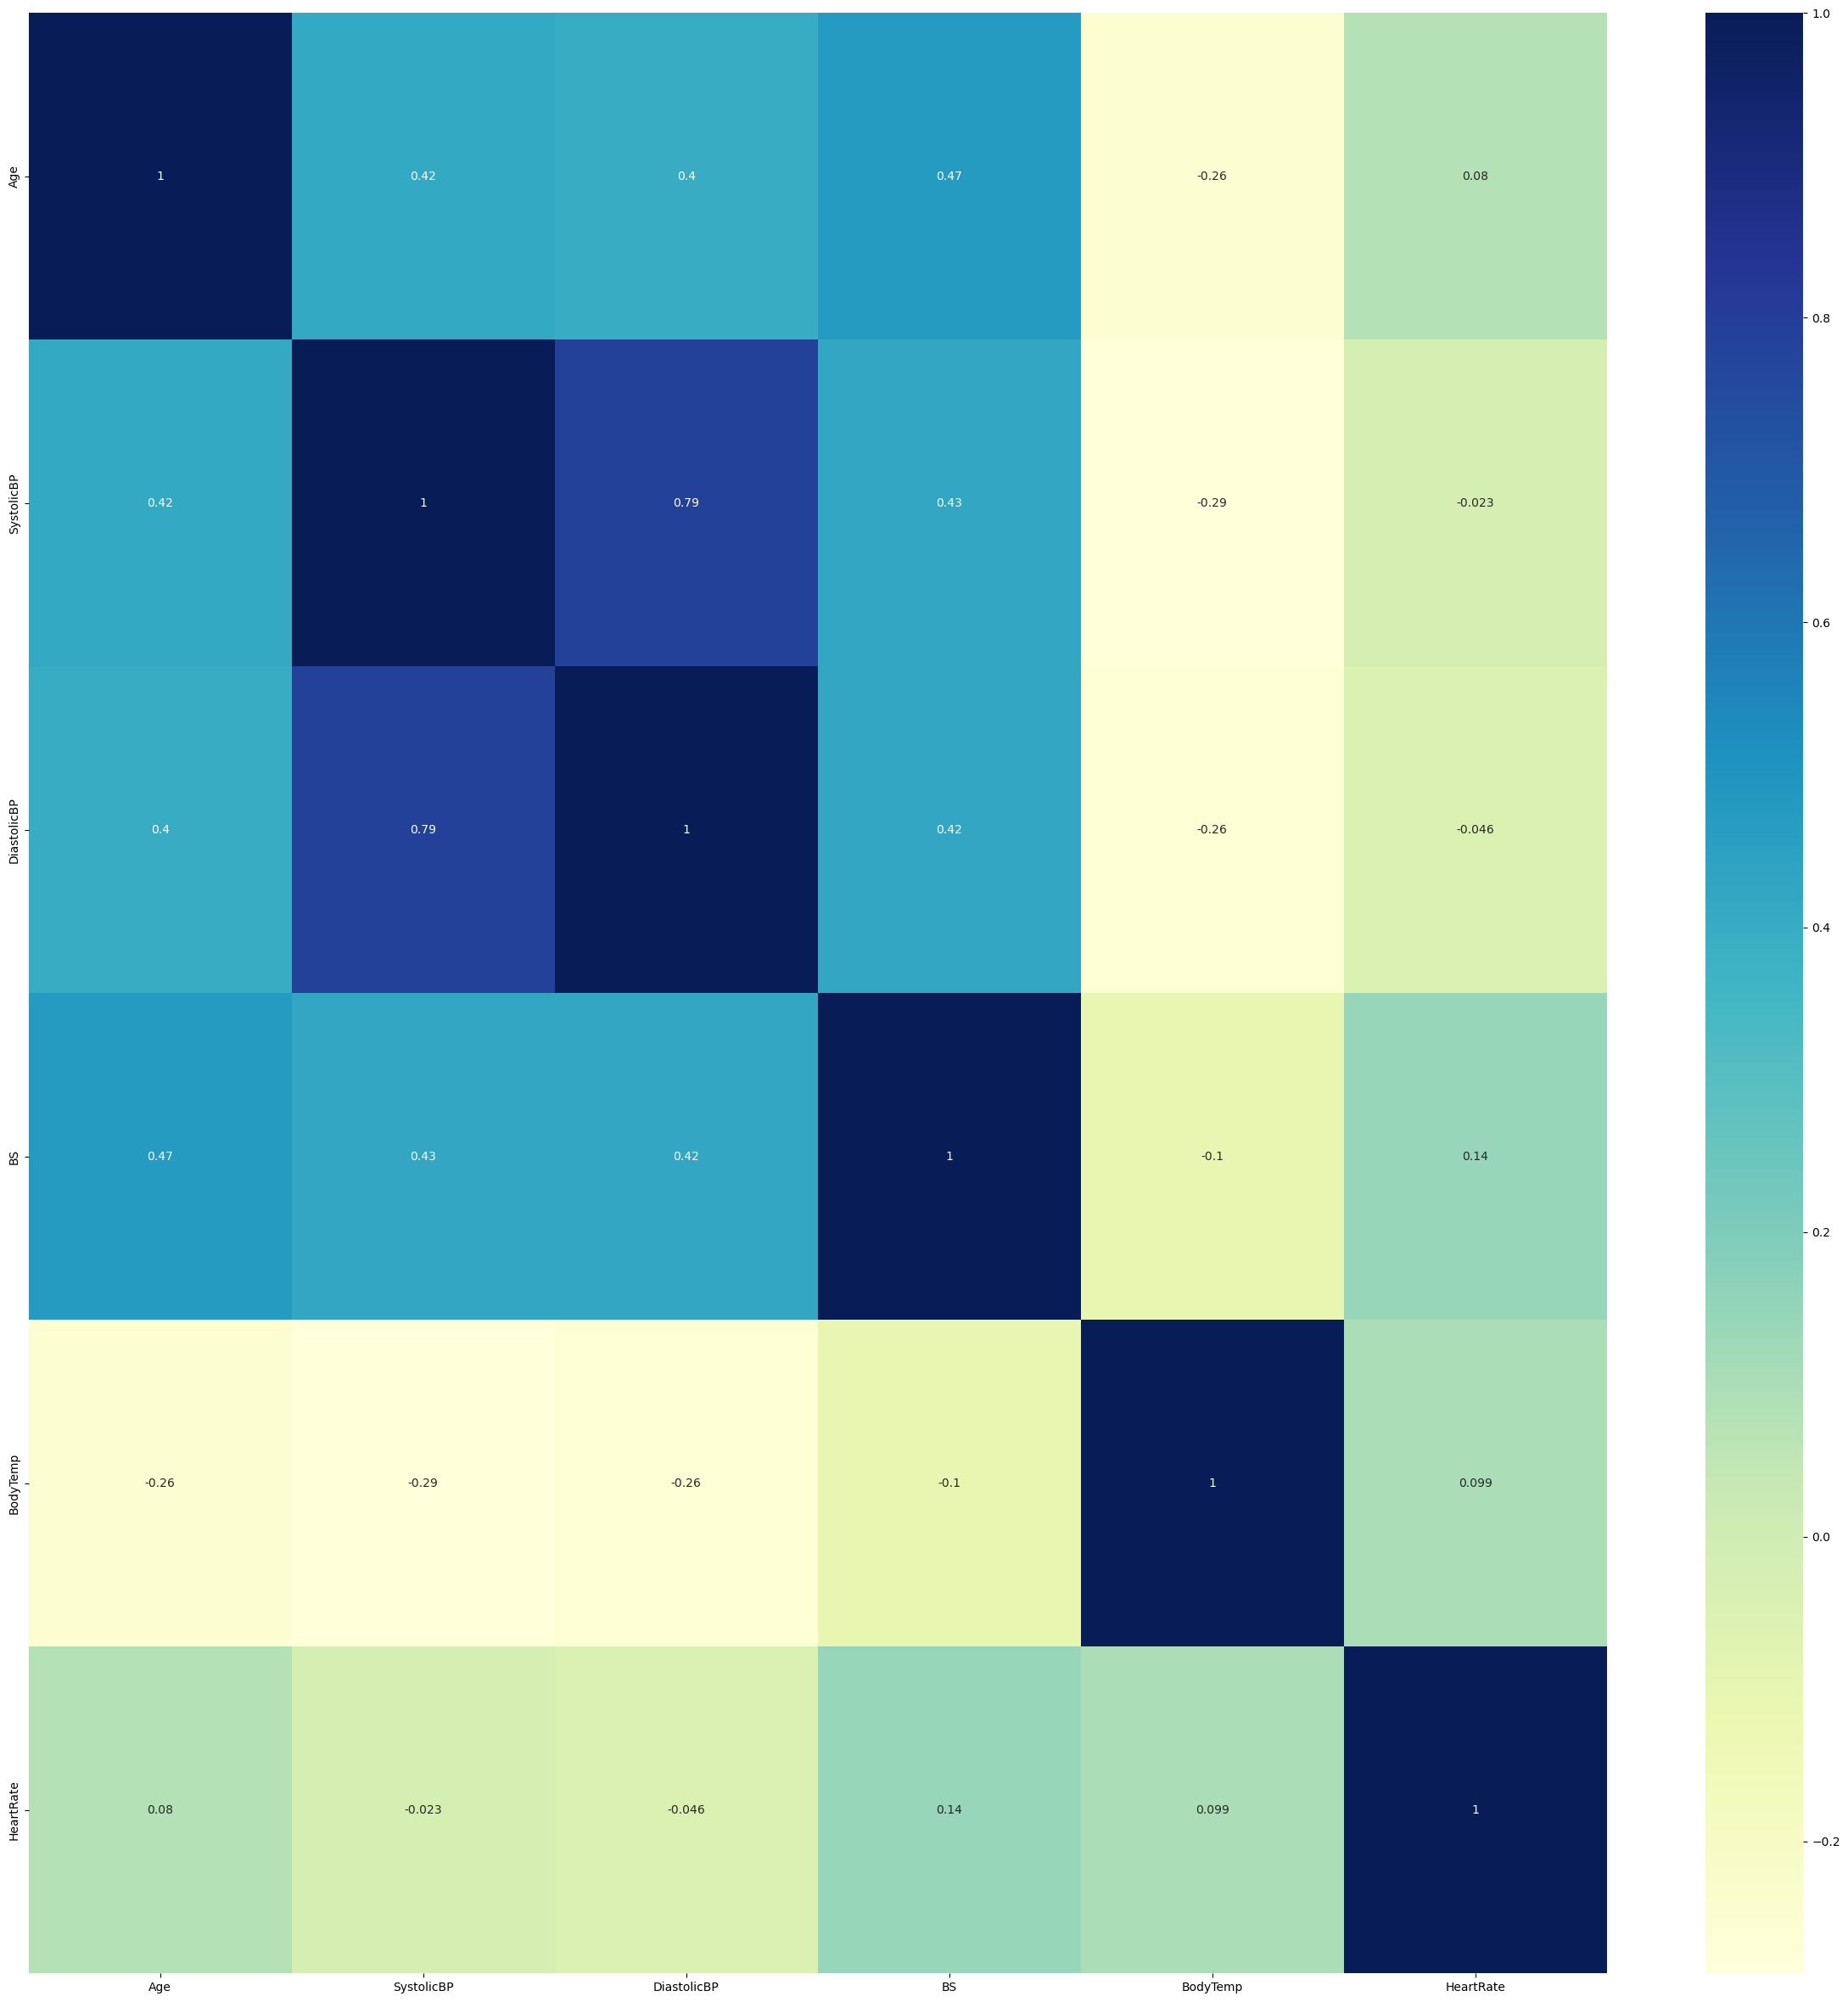

In [9]:
#построим корреляционную матрицу
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),cmap='YlGnBu', annot=True)

# 2. Произведем предобработку данных

# 2.1. Балансировка данных

Проверим на сбалансированность данных. Проверять будет по признаку RiskLevel  - прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего атрибута.

In [10]:
df['RiskLevel'].value_counts()

low risk     406
mid risk     336
high risk    272
Name: RiskLevel, dtype: int64

Данные не сбалансированны, реализуем балансировку используя методы oversampling SMOTE

In [11]:
df = balancing.data_balancing(df, 'RiskLevel')

In [12]:
df['RiskLevel'].value_counts()

high risk    406
low risk     406
mid risk     406
Name: RiskLevel, dtype: int64

In [13]:
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [14]:
df.shape

(1218, 7)

# 2.2. Кодирование данных

In [15]:
data = encoder.data_encoding(df)

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
data.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk'],
      dtype='object')

In [17]:
print(len(data.columns))

9


In [18]:
data.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
BodyTemp               0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

In [19]:
data.dtypes

Age                      int64
SystolicBP               int64
DiastolicBP              int64
BS                     float64
BodyTemp               float64
HeartRate                int64
RiskLevel_high risk    float64
RiskLevel_low risk     float64
RiskLevel_mid risk     float64
dtype: object

In [20]:
data.shape

(1218, 9)

# 2.3. Устранение дубликатов

In [21]:
#проверяем наличие дубликатов и удаляем их
data.drop_duplicates(inplace=True)

In [22]:
data.shape

(552, 9)

# 2.4. Работа с аномалиями

Проверяем на аномалии и устраняем их

Информация об атрибутах:

Age: Any ages in years when a women during pregnant.

SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.

DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.

BS: Blood glucose levels is in terms of a molar concentration, mmol/L.

HeartRate: A normal resting heart rate in beats per minute.

Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

In [23]:
#построим boxplot для каждого признака, чтобы посмотреть на наличие аномалий

<AxesSubplot:>

<Figure size 500x500 with 0 Axes>

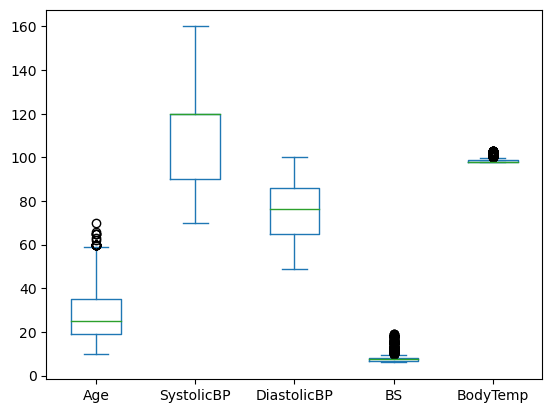

In [24]:
plt.figure(figsize=(5,5))

data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp']].plot(kind='box')

<AxesSubplot:>

<Figure size 500x500 with 0 Axes>

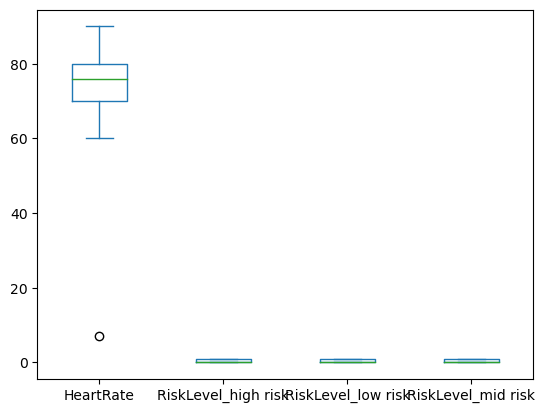

In [25]:
plt.figure(figsize=(5,5))

data[['HeartRate','RiskLevel_high risk', 'RiskLevel_low risk', 'RiskLevel_mid risk']].plot(kind='box')

Аномалии присутсвуют в таких признаках, как: 'Age', 'BS', 'BodyTemp', 'HeartRate'
посмотрим отдельно по каждому признаку с аномалиями значения его квартилей и выведем строки с непосредственно выбросами

In [26]:
#Смотрим на выбросы по признаку Age
Q1 =  data.Age.quantile(0.25)
Q3 = data.Age.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.Age < Q1-1.5*IQR ) | (data.Age > Q3+1.5*IQR)]

19.0
16.0
35.0


Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  \
36    60         120           80   6.1      98.0         75   
54    60          90           65   7.0      98.0         77   
91    60         120           85  15.0      98.0         60   
99    60          90           65   6.8      98.0         77   
114   63         140           90  15.0      98.0         90   
181   60         120           85  15.0      98.0         60   
280   60         120           80   7.7      98.0         75   
309   60          90           65   6.9      98.0         77   
313   62         120           80   6.9      98.0         66   
322   65          90           60   6.9      98.0         70   
323   60         120           80   6.9      98.0         76   
326   66          85           60   6.9      98.0         86   
338   70          85           60   6.9     102.0         70   
339   65         120           90   6.9     103.0         76   
375   60         120           80   7.8      98.0         75   
415   60         140           90  12.0      98.0         77   
417   60         140           80  16.0      98.0         66   
420   60         120           80   6.8      98.0         77   
435   65         130           80  15.0      98.0         86   
485   60          90           65   7.9      98.0         77   
515   60          90           65   7.5      98.0         77   
556   60         120           80   7.5      98.0         75   
601   60         120           80   7.5      98.0         75   

     RiskLevel_high risk  RiskLevel_low risk  RiskLevel_mid risk  
36                   0.0                 1.0                 0.0  
54                   0.0                 1.0                 0.0  
91                   0.0                 0.0                 1.0  
99                   0.0                 0.0                 1.0  
114                  1.0                 0.0                 0.0  
181                  1.0                 0.0                 0.0  
280                  0.0                 1.0                 0.0  
309                  0.0                 1.0                 0.0  
313                  0.0                 1.0                 0.0  
322                  0.0                 1.0                 0.0  
323                  0.0                 1.0                 0.0  
326                  0.0                 1.0                 0.0  
338                  0.0                 1.0                 0.0  
339                  0.0                 1.0                 0.0  
375                  1.0                 0.0                 0.0  
415                  1.0                 0.0                 0.0  
417                  1.0                 0.0                 0.0  
420                  0.0                 0.0                 1.0  
435                  1.0                 0.0                 0.0  
485                  0.0                 1.0                 0.0  
515                  0.0                 1.0                 0.0  
556                  0.0                 1.0                 0.0  
601                  0.0                 0.0                 1.0

In [27]:
len(data[(data.Age < Q1-1.5*IQR ) | (data.Age > Q3+1.5*IQR)])

23

По аризнаку Age получилось 23 выброса. Возраст в приведенных выбросах колеблется от 60 до 70 лет. Исходя из описания данных:
Age - возраст беременных женщин. Если брать статистику, то репродуктивном период у жензин длится примерно с 15 до 60 лет.
После этого возраста беременность практически невозможна. Поэтому удалим выбросы по этому признаку, так как сокрее всего 
это ошибка в данных.

In [28]:
data = data[(data.Age >= Q1-1.5*IQR ) & (data.Age <= Q3+1.5*IQR)]

In [29]:
#Смотрим на выбросы по признаку BS
Q1 =  data.BS.quantile(0.25)
Q3 = data.BS.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.BS < Q1-1.5*IQR ) | (data.BS > Q3+1.5*IQR)]

6.9
1.0999999999999996
8.0


Age  SystolicBP  DiastolicBP         BS    BodyTemp  HeartRate  \
0      25         130           80  15.000000   98.000000         86   
1      35         140           90  13.000000   98.000000         70   
7      35          85           60  11.000000  102.000000         86   
9      42         130           80  18.000000   98.000000         70   
14     48         120           80  11.000000   98.000000         88   
...   ...         ...          ...        ...         ...        ...   
1133   24          98           63  11.315226   99.027161         82   
1138   23         120           62  13.536062   98.000000         80   
1140   25         120           90  13.179293   99.820707         80   
1153   43         120           90  15.820289   98.000000         80   
1217   42         120           91  14.129300   98.000000         80   

      RiskLevel_high risk  RiskLevel_low risk  RiskLevel_mid risk  
0                     1.0                 0.0                 0.0  
1                     1.0                 0.0                 0.0  
7                     1.0                 0.0                 0.0  
9                     1.0                 0.0                 0.0  
14                    0.0                 0.0                 1.0  
...                   ...                 ...                 ...  
1133                  1.0                 0.0                 0.0  
1138                  1.0                 0.0                 0.0  
1140                  1.0                 0.0                 0.0  
1153                  0.0                 0.0                 1.0  
1217                  0.0                 0.0                 1.0  

[95 rows x 9 columns]

In [30]:
len(data[(data.BS < Q1-1.5*IQR ) | (data.BS > Q3+1.5*IQR)])

95

По признаку BS было вявлено 65 выбросов. Данный признак говорит об уровне глюкозы в крови ммоль/л. Уроень глюкозы в выбросах варьируется от 11 до 19 ммоль/л. Такой уровень глюкозы может видетельстовать о наличии сахарного диабета у пциента. Эти данные вполне могут иметь место быть, поэтому данные выбросы необходимо будет учесть и их нельзя заменять или удалять

In [31]:
Q1 =  data.BodyTemp.quantile(0.25)
Q3 = data.BodyTemp.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.BodyTemp < Q1-1.5*IQR ) | (data.BodyTemp > Q3+1.5*IQR)]

98.0
1.0
99.0


Age  SystolicBP  DiastolicBP         BS    BodyTemp  HeartRate  \
7      35          85           60  11.000000  102.000000         86   
18     30         120           80   6.900000  101.000000         76   
35     12          95           60   6.100000  102.000000         60   
66     17          85           60   9.000000  102.000000         86   
69     32         120           65   6.000000  101.000000         76   
...   ...         ...          ...        ...         ...        ...   
1182   32         119           65   6.164020  100.507940         75   
1190   30         120           80   7.296118  101.000000         76   
1193   18         120           80   6.900000  100.951588         76   
1196   17          87           60   9.000000  102.000000         86   
1215   55          99           69   6.800000  100.864088         79   

      RiskLevel_high risk  RiskLevel_low risk  RiskLevel_mid risk  
7                     1.0                 0.0                 0.0  
18                    0.0                 0.0                 1.0  
35                    0.0                 1.0                 0.0  
66                    0.0                 0.0                 1.0  
69                    0.0                 0.0                 1.0  
...                   ...                 ...                 ...  
1182                  0.0                 0.0                 1.0  
1190                  0.0                 0.0                 1.0  
1193                  0.0                 0.0                 1.0  
1196                  0.0                 0.0                 1.0  
1215                  0.0                 0.0                 1.0  

[110 rows x 9 columns]

In [32]:
len(data[(data.BodyTemp < Q1-1.5*IQR ) | (data.BodyTemp > Q3+1.5*IQR)])

110

In [33]:
print(data.BodyTemp.mean())
print(data.BodyTemp.median())

98.82021400856974
98.0


В признаке BodyTemp обнаружено около половины выбросов. BodyTemp - признак отвечающий за температуру тела. Среднее арифметическое по признаку равно 98.7, а медианное 98. Вероятно при занесении данных в датасет была произведена ошибка на всех пациентах. Поэтому есть смысл удалить этот столбец, чтобы он не влиял в дальнейшем на результаты

In [34]:
data = data.drop(columns=['BodyTemp'])

In [35]:
Q1 =  data.HeartRate.quantile(0.25)
Q3 = data.HeartRate.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.HeartRate < Q1-1.5*IQR ) | (data.HeartRate > Q3+1.5*IQR)]

70.0
10.0
80.0


Age  SystolicBP  DiastolicBP   BS  HeartRate  RiskLevel_high risk  \
499   16         120           75  7.9          7                  0.0   

     RiskLevel_low risk  RiskLevel_mid risk  
499                 1.0                 0.0

In [36]:
print(data.HeartRate.mean())
print(data.HeartRate.median())

74.40453686200378
76.0


По признаку HeartRate есть один выброс. HeartRate  - признак, который отвечает за нормальную частоту сердечных сокращений в состоянии покоя в ударах в минуту. Исходя из статистики средняя частота сердечных сокращений взрослого человека составляет от 60 до 80 ударов в минуту. В выбросе показатель равен 7, что явно является ошибкой и данный выброс можно не учитывать 

In [37]:
data = data[(data.HeartRate >= Q1-1.5*IQR ) & (data.HeartRate <= Q3+1.5*IQR)]

# 2.5. Масштабирование данных

Произведем масштабирование данных

In [38]:
data = scaling.data_scaling(data)

In [39]:
data

Age  SystolicBP  DiastolicBP        BS  HeartRate  \
0    -0.232597    1.048126     0.324912  2.225746   1.529157   
1     0.610887    1.599496     1.046636  1.539449  -0.604339   
2     0.104797   -1.157355    -0.396811 -0.176293   0.729096   
3     0.189145    1.599496     0.685774 -0.519441  -0.604339   
4     0.610887    0.496755    -1.118535 -0.828275   0.195722   
...        ...         ...          ...       ...        ...   
1209  0.610887    0.496755     0.685774 -0.535688   0.729096   
1213 -0.569991    0.496755    -0.035949 -0.306795  -0.604339   
1215  2.297856   -0.661122    -0.468984 -0.588071   0.595753   
1216 -0.907385   -1.157355    -1.046362 -0.553756  -0.604339   
1217  1.201326    0.496755     1.118808  1.926966   0.729096   

      RiskLevel_high risk  RiskLevel_low risk  RiskLevel_mid risk  
0                1.444894           -0.845154           -0.591932  
1                1.444894           -0.845154           -0.591932  
2                1.444894           -0.845154           -0.591932  
3                1.444894           -0.845154           -0.591932  
4               -0.692092            1.183216           -0.591932  
...                   ...                 ...                 ...  
1209            -0.692092           -0.845154            1.689383  
1213            -0.692092           -0.845154            1.689383  
1215            -0.692092           -0.845154            1.689383  
1216            -0.692092           -0.845154            1.689383  
1217            -0.692092           -0.845154            1.689383  

[528 rows x 8 columns]

# 3. Работаем с пропусками

data - после предобработки данных был получен эталонный датасет с которым будет происходить сравнение по метрикам

In [40]:
data.isna().sum()

Age                    0
SystolicBP             0
DiastolicBP            0
BS                     0
HeartRate              0
RiskLevel_high risk    0
RiskLevel_low risk     0
RiskLevel_mid risk     0
dtype: int64

In [41]:
data.shape

(528, 8)

# 3.1. Искусственно создаем пропуски

In [42]:
# искусственно создаем пропуски в данных, которые впоследствии будем заполнять
# выбираем случайный признак
df_copy = data.copy()
np.random.seed(5)

random_feature = np.random.choice(df_copy.columns)

In [43]:
df1 = deletion_features.make_missing_value(df_copy, 0.05, random_feature)

<AxesSubplot:>

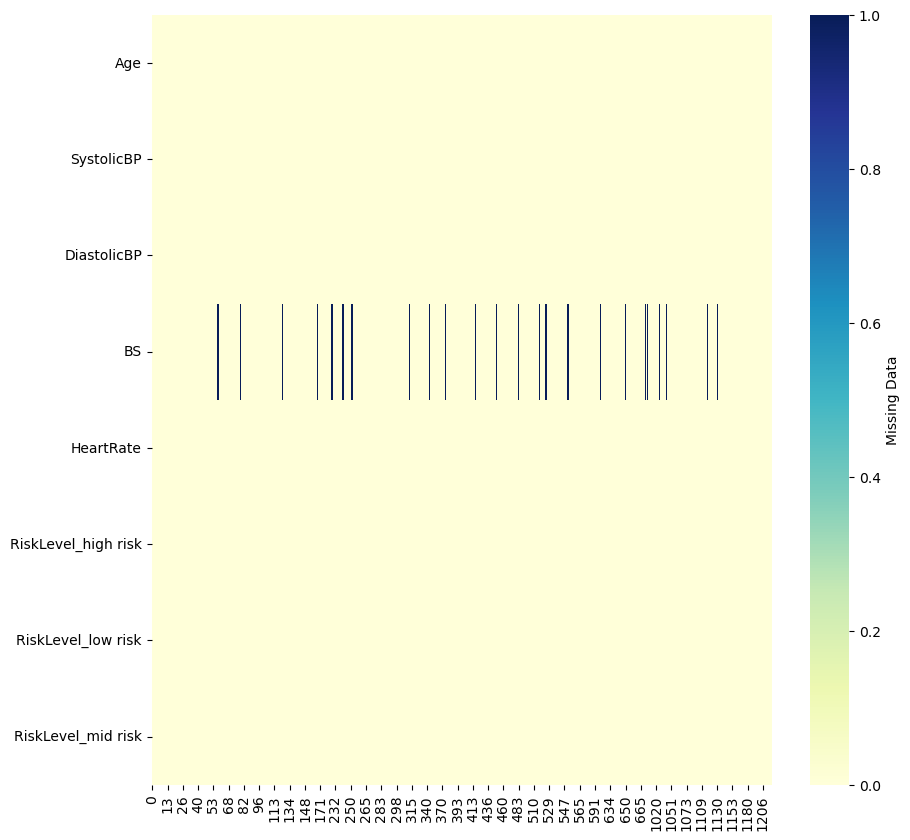

In [44]:
#визуализируем наличие пропусков
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(df1).isna().transpose(), cmap = "YlGnBu", cbar_kws={'label':'Missing Data'})

In [45]:
df1.isna().sum()

Age                     0
SystolicBP              0
DiastolicBP             0
BS                     26
HeartRate               0
RiskLevel_high risk     0
RiskLevel_low risk      0
RiskLevel_mid risk      0
dtype: int64

создадим датасет с 20% пропусков для сравнения результатов заполнения

In [46]:
df15 = deletion_features.make_missing_value(df_copy, 0.2, random_feature)
df15.isna().sum()

Age                      0
SystolicBP               0
DiastolicBP              0
BS                     105
HeartRate                0
RiskLevel_high risk      0
RiskLevel_low risk       0
RiskLevel_mid risk       0
dtype: int64

In [47]:
df20 = deletion_features.make_missing_value(df_copy, 0.35, random_feature)
df20.isna().sum()

Age                      0
SystolicBP               0
DiastolicBP              0
BS                     184
HeartRate                0
RiskLevel_high risk      0
RiskLevel_low risk       0
RiskLevel_mid risk       0
dtype: int64

In [48]:
df1.isna().sum()

Age                     0
SystolicBP              0
DiastolicBP             0
BS                     26
HeartRate               0
RiskLevel_high risk     0
RiskLevel_low risk      0
RiskLevel_mid risk      0
dtype: int64

# 3.2. Заполняем пропуски

#1. Заполним пропуски средним арифметическим значением по признаку

In [49]:
df_mean_fill = mean_fill.mean_fill(df1)

#2. Заполним пропуски медианным значением по признаку

In [50]:
df_median_fill = median_fill.median_fill(df1)

#3. Заполним пропуски минимальным значением по признаку

In [51]:
df_min_fill = min_fill.min_fill(df1)

#4. Заполним пропуски максимальным значением по признаку

In [52]:
df_max_fill = df_min_fill = max_fill.max_fill(df1)

#5. Заполним пропуски используя интерполяцию

In [53]:
df_interpolate_fill = interpolate_fill.interpolate_fill(df1)

#6. Заполним пропуски используя линейную регрессию

In [54]:
df_LinearReg_fill = LinearRegression_fill.linreg_imputer(df1)

#7 Заполним пропуски используя KNNImputer

In [55]:
df_KNNImputer_fill = KNNImputer_fill.KNNImputer_fill(df1)

#8 Заполним пропуски используя дерево решений

In [56]:
df_DecisionTree_fill = DecisionTreeRegressor_fill.DecisionTree_imputer(df1)

#9 Заполним пропуски используя случайный лес

In [57]:
df_RandomForest_fill = RandomForestRegressor_fill.RandomForest_imputer(df1)

#10 Заполним пропуски используя SVM

In [58]:
df_SVM_fill = SVR_fill.SVM_imputer(df1)

#11 Заполним пропуски используя градиентный бустинг - XGboost

In [59]:
df_XGBRegressor_fill = XGBRegressor_fill.XGBRegressor_imputer(df1)

#12 Заполним пропуски используя градиентный бустинг - CatBoost

In [60]:
df_CatBoostRegressor_fill = CatBoostRegressor_fill.CatBoostRegressor_imputer(df1)

# 4. Формируем результаты эксперимента

In [61]:
all_methods = [df_mean_fill, df_median_fill, df_min_fill, df_max_fill, df_interpolate_fill, df_LinearReg_fill, df_KNNImputer_fill, df_DecisionTree_fill, df_RandomForest_fill, df_SVM_fill, df_XGBRegressor_fill, df_CatBoostRegressor_fill]
df1_result = results_metrics.generate_results_metrics(data, all_methods)
df1_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.003688            0.004763  0.995048
Median                        0.002340            0.004604  0.995244
Min                           0.023409            0.093502  0.940240
Max                           0.023409            0.093502  0.940240
Interpolate                   0.004263            0.007627  0.992391
LinearReg                     0.003669            0.004099  0.995832
KNNImputer                    0.003039            0.004079  0.995824
DecisionTree                  0.002149            0.001397  0.998607
RandomForest                  0.002523            0.001763  0.998211
SVM                           0.002929            0.003666  0.996235
XGBRegressor                  0.001846            0.000831  0.999166
CatBoostRegressor             0.002121            0.001154  0.998838

In [62]:
all_methods = [mean_fill.mean_fill(df15), median_fill.median_fill(df15), min_fill.min_fill(df15), max_fill.max_fill(df15), interpolate_fill.interpolate_fill(df15),
              LinearRegression_fill.linreg_imputer(df15), KNNImputer_fill.KNNImputer_fill(df15), DecisionTreeRegressor_fill.DecisionTree_imputer(df15),
              RandomForestRegressor_fill.RandomForest_imputer(df15), SVR_fill.SVM_imputer(df15), XGBRegressor_fill.XGBRegressor_imputer(df15), CatBoostRegressor_fill.CatBoostRegressor_imputer(df15)]
df15_result = results_metrics.generate_results_metrics(data, all_methods)
df15_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.017462            0.023816  0.970580
Median                        0.013847            0.026323  0.968269
Min                           0.020738            0.041086  0.955822
Max                           0.090152            0.350736  0.877549
Interpolate                   0.015593            0.028132  0.969321
LinearReg                     0.012256            0.013363  0.984891
KNNImputer                    0.009028            0.008680  0.990498
DecisionTree                  0.007442            0.007544  0.992609
RandomForest                  0.006812            0.004715  0.994997
SVM                           0.009717            0.012429  0.985967
XGBRegressor                  0.006820            0.005333  0.994556
CatBoostRegressor             0.006024            0.003382  0.996414

In [63]:
all_methods = [mean_fill.mean_fill(df20), median_fill.median_fill(df20), min_fill.min_fill(df20), max_fill.max_fill(df20), interpolate_fill.interpolate_fill(df20), 
              LinearRegression_fill.linreg_imputer(df20), KNNImputer_fill.KNNImputer_fill(df20), DecisionTreeRegressor_fill.DecisionTree_imputer(df20),
              RandomForestRegressor_fill.RandomForest_imputer(df20), SVR_fill.SVM_imputer(df20), XGBRegressor_fill.XGBRegressor_imputer(df20), CatBoostRegressor_fill.CatBoostRegressor_imputer(df20)]
df20_result = results_metrics.generate_results_metrics(data, all_methods)
df20_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.031517            0.051898  0.911721
Median                        0.027461            0.059673  0.901743
Min                           0.042083            0.091454  0.875714
Max                           0.152238            0.582847  0.838939
Interpolate                   0.028797            0.057454  0.922942
LinearReg                     0.024367            0.030889  0.956884
KNNImputer                    0.019329            0.021954  0.971764
DecisionTree                  0.019076            0.031037  0.967424
RandomForest                  0.017257            0.019744  0.975894
SVM                           0.020021            0.030033  0.958184
XGBRegressor                  0.017538            0.022477  0.974609
CatBoostRegressor             0.016531            0.018221  0.978695

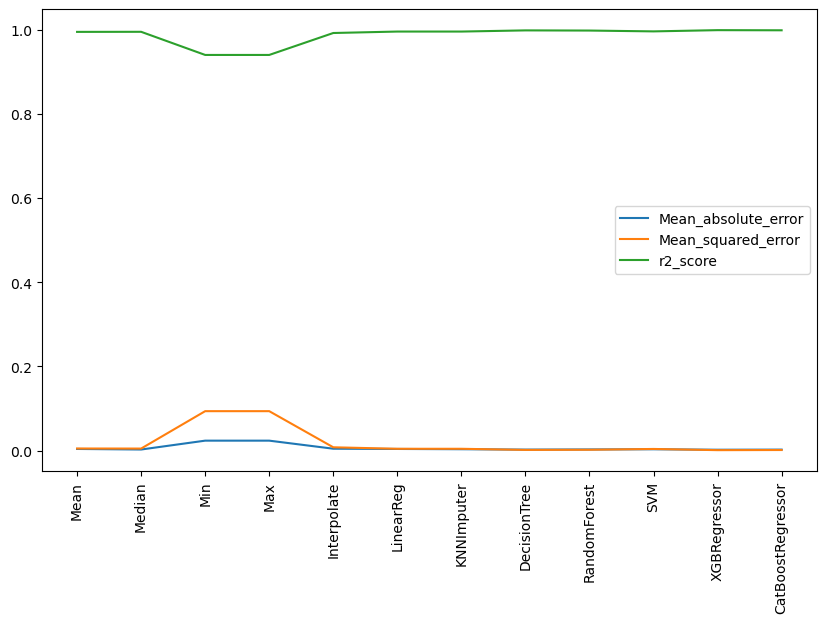

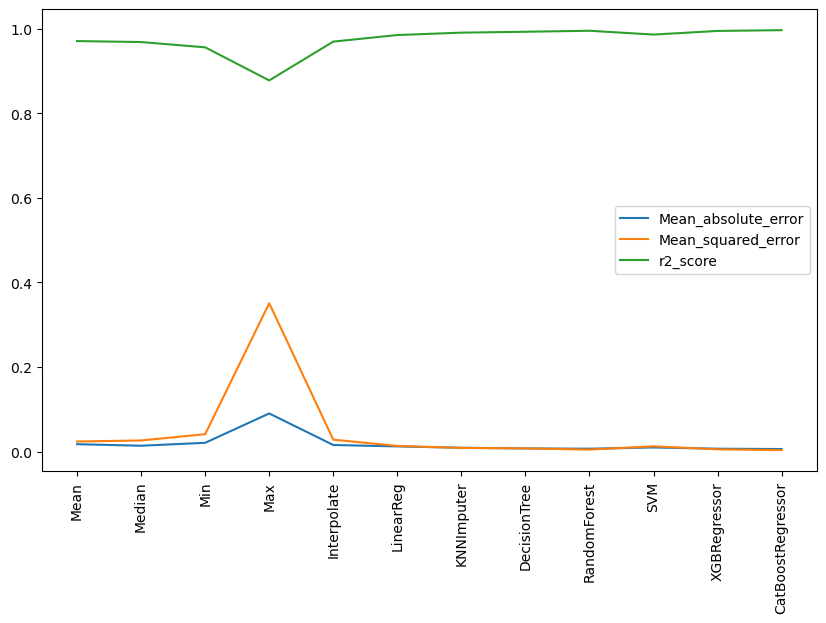

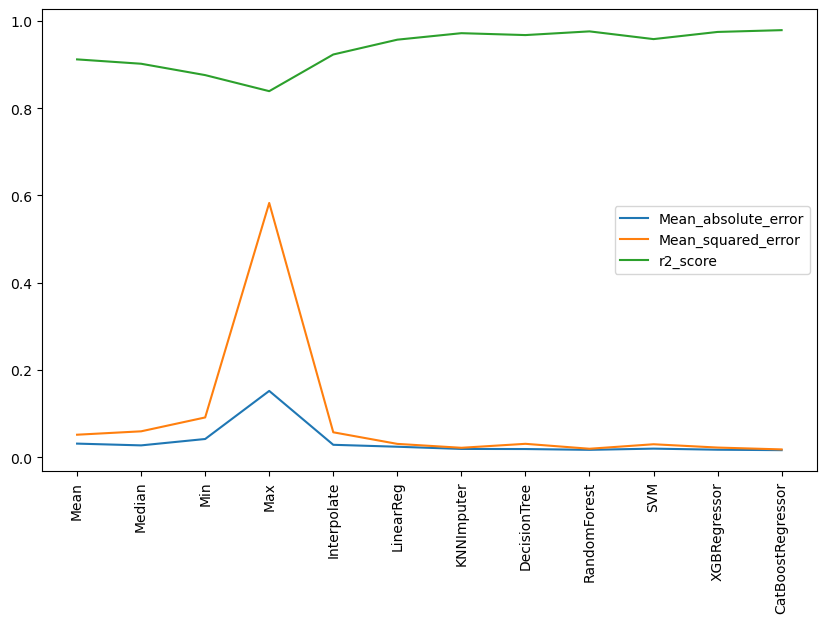

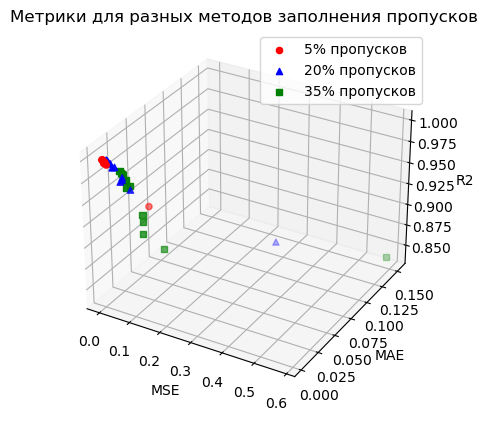

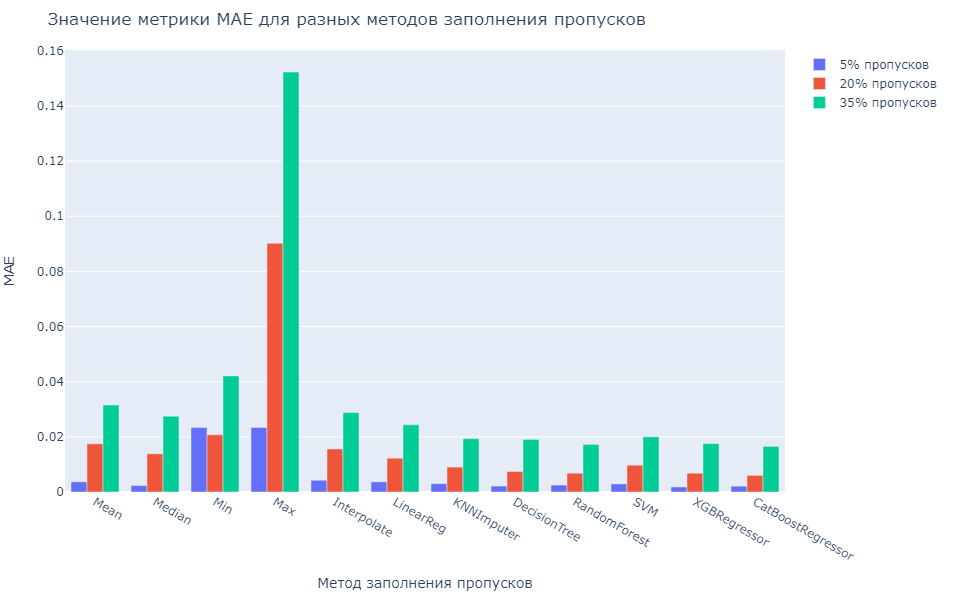

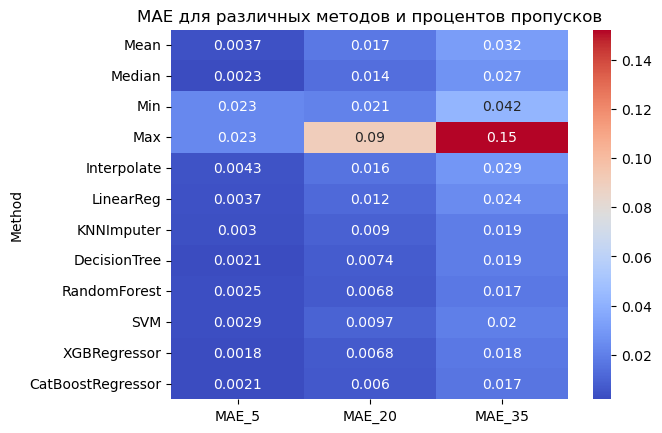

C:\Users\Ivan\Documents\university\ЮФУ_1_курс\Научные работы\Работа 6. Заполнение пропусков\Filling-in-Missing-Values\research\evaluate\results_metrics_visualization.py:143: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Ivan\Documents\university\ЮФУ_1_курс\Научные работы\Работа 6. Заполнение пропусков\Filling-in-Missing-Values\research\evaluate\results_metrics_visualization.py:144: UserWarning:

FixedFormatter should only be used together with FixedLocator



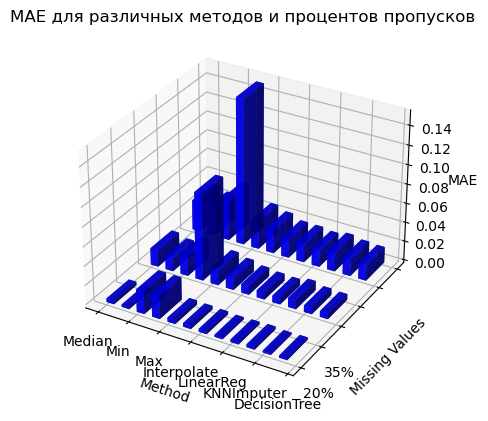

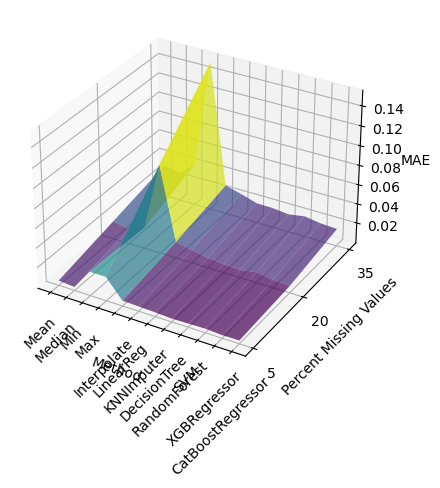

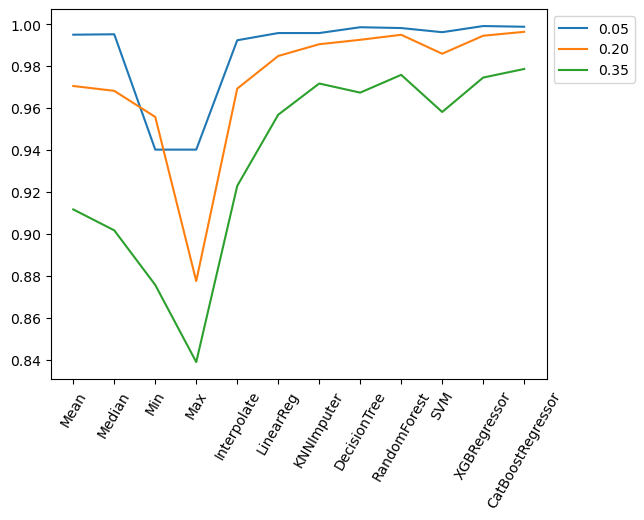

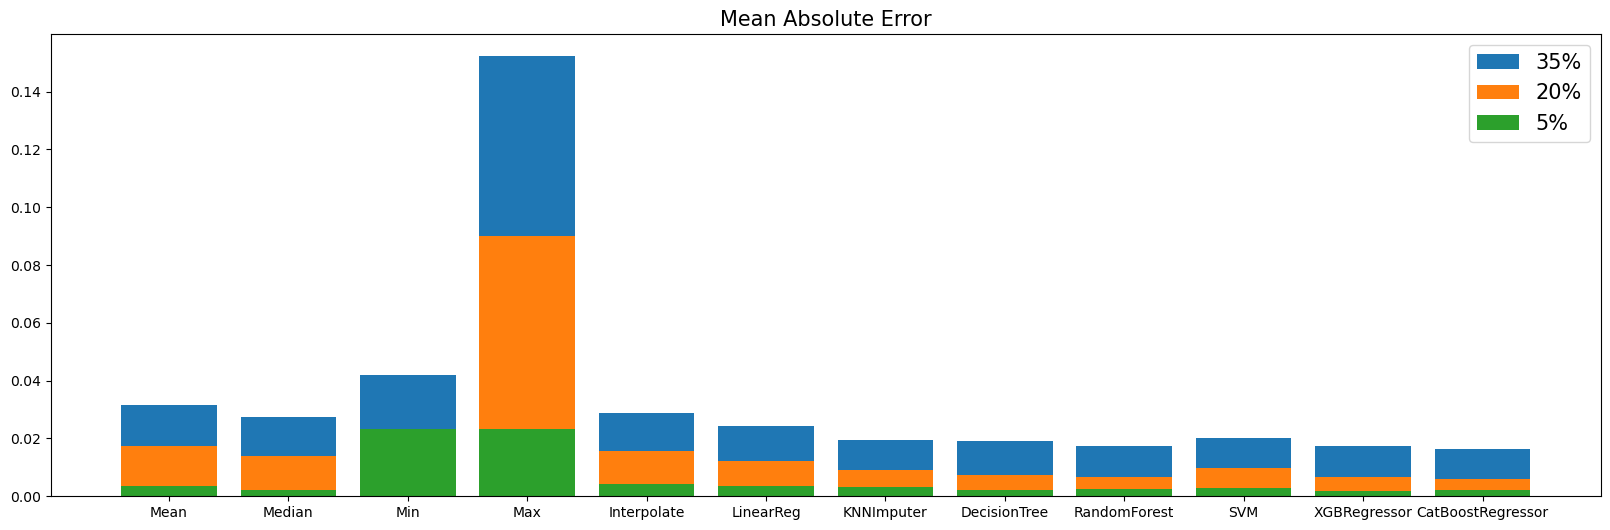

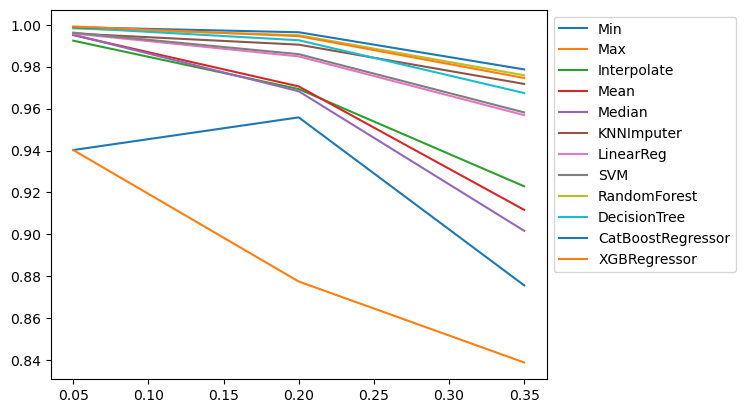

In [64]:
results_metrics_visualization.visualization_results_metrics(df1_result, df15_result, df20_result)